# HOG

C:\Users\krzys\AppData\Local\Temp\ipykernel_2072\4023382457.py:24: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(im), np.array([-1, 0, 1]), 1)
C:\Users\krzys\AppData\Local\Temp\ipykernel_2072\4023382457.py:25: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dy = scipy.ndimage.filters.convolve1d(np.int32(im), np.array([-1, 0, 1]), 0)


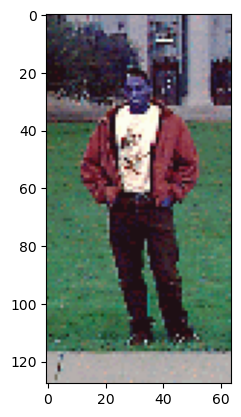

In [1]:
import cv2
import matplotlib.pyplot as plt
import scipy
import numpy as np

img = cv2.imread('train/pos/per00060.ppm')
plt.imshow(img)

def gradients(img):

    dims = None
    magnitude = np.zeros_like(img)
    Gx = np.zeros_like(img)
    Gy = np.zeros_like(img)
    if len(img.shape) == 3: #bgr
        dims = 3
    else: #gray
        dims = 1 
    for dim in range(dims):
        im = img #gray
        if dims == 3: #bgr
            im = img[:, :, dim]

        dx = scipy.ndimage.filters.convolve1d(np.int32(im), np.array([-1, 0, 1]), 1)
        dy = scipy.ndimage.filters.convolve1d(np.int32(im), np.array([-1, 0, 1]), 0)
        mag = np.sqrt(dx**2 + dy**2)

        if dims == 3: #bgr
            Gx[:, :, dim] = dx
            Gy[:, :, dim] = dy
            magnitude[:, :, dim] = mag
        else: #gray
            Gx = dx
            Gy = dy
            magnitude = mag
    
    mag_max = np.zeros((img.shape[0], img.shape[1])) #final m
    theta = np.zeros((img.shape[0], img.shape[1])) #final gradient direcion

    if dims == 1: #gray
        mag_max = magnitude
        theta = np.arctan2(Gy, Gx)
    elif dims == 3: #bgr
        max_B = np.logical_and(magnitude[:, :, 1] < magnitude[:, :, 0], magnitude
                            [:, :, 2] < magnitude[:, :, 0])
        max_G = np.logical_and(magnitude[:, :, 0] < magnitude[:, :, 1], magnitude
                            [:, :, 2] < magnitude[:, :, 1])
        max_R = np.logical_and(magnitude[:, :, 0] < magnitude[:, :, 2], magnitude
                            [:, :, 1] < magnitude[:, :, 2])
        
        mag_max[max_B] = magnitude[:, :, 0][max_B]
        mag_max[max_G] = magnitude[:, :, 1][max_G]
        mag_max[max_R] = magnitude[:, :, 2][max_R]

        Gx_max = np.zeros_like(mag_max)
        Gy_max = np.zeros_like(mag_max)

        Gx_max[max_B] = Gx[:, :, 0][max_B]
        Gx_max[max_G] = Gx[:, :, 1][max_G]
        Gx_max[max_R] = Gx[:, :, 2][max_R]

        Gy_max[max_B] = Gy[:, :, 0][max_B]
        Gy_max[max_G] = Gy[:, :, 1][max_G]
        Gy_max[max_R] = Gy[:, :, 2][max_R]

        theta = np.arctan2(Gy_max, Gx_max)
        # theta = np.degrees(theta)
        theta = np.rad2deg(theta)
        # theta %= 180

    return mag_max, theta

mag_max, theta = gradients(img)

In [2]:
def histogram(mag, theta, img):
    cellSize = 8
    YY, XX = img.shape[:2]
    YY_cell=np.int32(YY/cellSize)
    XX_cell=np.int32(XX/cellSize)
    mids = np.array([x for x in range(10, 180, 20)])
    hists = np.zeros((YY_cell, XX_cell, mids.size))

    for y in range(0, img.shape[0], YY_cell):
        for x in range(0, img.shape[1], XX_cell):
            
            mag_cell = mag[y:y+cellSize, x:x+cellSize]
            theta_cell = theta[y:y+cellSize, x:x+cellSize]
            for i in range(theta_cell.shape[0]):
                for j in range(theta_cell.shape[1]):
                    curr_theta = theta_cell[i, j]
                    curr_mag = mag_cell[i, j]

                    diff = np.abs(curr_theta - mids)

                    if curr_theta < mids[0]:
                        first_bin_idx = 0
                        second_bin_idx = mids.size-1
                    elif curr_theta > mids[-1]:
                        first_bin_idx = mids.size-1
                        second_bin_idx = 0
                    else:
                        first_bin_idx = np.where(diff == np.min(diff))[0][0]
                        temp = mids[[(first_bin_idx-1)%mids.size, (first_bin_idx+1)%mids.size]]
                        temp2 = np.abs(curr_theta - temp)
                        res = np.where(temp2 == np.min(temp2))[0][0]
                        if res == 0 and first_bin_idx != 0:
                            second_bin_idx = first_bin_idx - 1
                        else:
                            second_bin_idx = first_bin_idx + 1
                    
                    first_bin_value = mids[first_bin_idx]
                    second_bin_value = mids[second_bin_idx]

                    y_cur = y // YY_cell
                    x_cur = x // XX_cell
                    hists[y_cur, x_cur, first_bin_idx] += (np.abs(curr_theta - first_bin_value)/(180.0/mids.size)) * curr_mag
                    hists[y_cur, x_cur, second_bin_idx] += (np.abs(curr_theta - second_bin_value)/(180.0/mids.size)) * curr_mag


    return hists

hists = histogram(mag_max, theta, img)

In [3]:
import math

def normalize_hists(hists):
    e = math.pow(1e-5, 2)
    F = []
    for i in range(hists.shape[0]-1):
        for j in range(hists.shape[1]-1):
            H0 = hists[i, j, :]
            H1 = hists[i, j+1, :]
            H2 = hists[i+1, j, :]
            H3 = hists[i+1, j+1, :]
            H = np.concatenate((H0, H1, H2, H3))
            n = np.linalg.norm(H)
            Hn = H/np.sqrt(math.pow(n, 2)+e)
            F = np.concatenate((F, Hn))
    return F

norm_hists = normalize_hists(hists)
print(norm_hists)

[0.04329648 0.04728906 0.02664785 ... 0.         0.         0.        ]


In [4]:
def hog(img):
    mag_max, theta = gradients(img)
    hists = histogram(mag_max, theta, img)
    norm_hists = normalize_hists(hists)
    return norm_hists

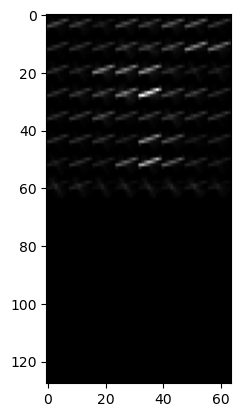

In [5]:
import skimage as ski

def HOGpicture(hists, cellSize=8):
    bim1 = np.zeros((cellSize, cellSize))
    bim1[np.round(cellSize//2):np.round(cellSize//2)+1, :] = 1
    bim = np.zeros(bim1.shape+(9,))
    bim[:, :, 0] = bim1
    for i in range(0, 9):
        # bim[:, :, i] = scipy.misc.imrotate(bim1, -i*20, 'nearest')/255
        bim[:, :, i] = ski.transform.rotate(bim1, -i*20)/255
    Y, X, Z = hists.shape
    hists[hists < 0] = 0
    im = np.zeros((cellSize*Y, cellSize*X)) 
    for i in range(Y):
        iisl = (i)*cellSize
        iisu = (i+1)*cellSize
        for j in range(X):
            jjsl = j*cellSize
            jjsu = (j+1)*cellSize
            for k in range(9):
                im[iisl:iisu, jjsl:jjsu] += bim[:, :, k] * hists[i, j, k]
    return im

hist_img = HOGpicture(hists)
plt.imshow(hist_img, 'gray')

# SVM

In [6]:
HOG_data = np.zeros([2*100, 3781], np.float32)

for i in range (0, 100):
    IP = cv2.imread ('train/pos/per%05d.ppm' % (i + 1))
    IN = cv2.imread ('train/neg/neg%05d.png' % (i + 1))
    F = hog(IP)
    HOG_data[i, 0] = 1
    HOG_data[i, 1:] = F
    F = hog(IN)
    HOG_data[i + 100, 0] = 0
    HOG_data[i + 100, 1:] = F

C:\Users\krzys\AppData\Local\Temp\ipykernel_2072\4023382457.py:24: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(im), np.array([-1, 0, 1]), 1)
C:\Users\krzys\AppData\Local\Temp\ipykernel_2072\4023382457.py:25: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dy = scipy.ndimage.filters.convolve1d(np.int32(im), np.array([-1, 0, 1]), 0)


In [7]:
from sklearn import svm

labels = HOG_data[:, 0]
data = HOG_data[:, 1:]

clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(data, labels)
lp = clf.predict(data)

In [8]:
def show_metrics(lp, labels):
    TP = np.count_nonzero(np.bitwise_and(lp == 1, labels == 1))
    TN = np.count_nonzero(np.bitwise_and(lp == 0, labels == 0))
    FP = np.count_nonzero(np.bitwise_and(lp == 1, labels == 0))
    FN = np.count_nonzero(np.bitwise_and(lp == 0, labels == 1))
    print(f'TP: {TP}\nTN: {TN}\nFP: {FP}\nFN: {FN}')
    print(f'Accuracy: {(TP+TN)/len(lp)}')

show_metrics(lp, labels)

TP: 100
TN: 100
FP: 0
FN: 0
Accuracy: 1.0


In [9]:
HOG_data_test = np.zeros([2*100, 3781], np.float32)

for i in range (100, 200):
    IP = cv2.imread ('train/pos/per%05d.ppm' % (i + 1))
    IN = cv2.imread ('train/neg/neg%05d.png' % (i + 1))
    F = hog(IP)
    HOG_data_test[i-100, 0] = 1
    HOG_data_test[i-100, 1:] = F
    F = hog(IN)
    HOG_data_test[i, 0] = 0
    HOG_data_test[i, 1:] = F

test_labels = HOG_data[:, 0]
test_data = HOG_data[:, 1:]
test_predicts = clf.predict(test_data)

show_metrics(test_predicts, test_labels)

C:\Users\krzys\AppData\Local\Temp\ipykernel_2072\4023382457.py:24: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(im), np.array([-1, 0, 1]), 1)
C:\Users\krzys\AppData\Local\Temp\ipykernel_2072\4023382457.py:25: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dy = scipy.ndimage.filters.convolve1d(np.int32(im), np.array([-1, 0, 1]), 0)


TP: 100
TN: 100
FP: 0
FN: 0
Accuracy: 1.0


# FINAL DETECTOR

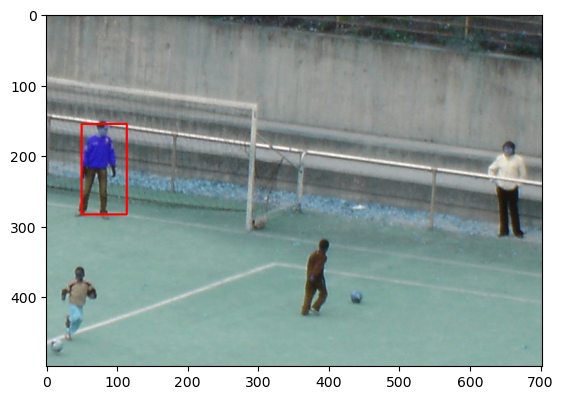

In [10]:
img = cv2.imread('test/testImage1.png')
pp = (50, 155)
cv2.rectangle(img, pp, (pp[0] + 64, pp[1] + 128), (255, 0, 0), 2)
plt.imshow(img)

C:\Users\krzys\AppData\Local\Temp\ipykernel_2072\4023382457.py:24: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(im), np.array([-1, 0, 1]), 1)
C:\Users\krzys\AppData\Local\Temp\ipykernel_2072\4023382457.py:25: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dy = scipy.ndimage.filters.convolve1d(np.int32(im), np.array([-1, 0, 1]), 0)
C:\Users\krzys\AppData\Local\Temp\ipykernel_2072\4023382457.py:24: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(im), np.array([-1, 0, 1]), 1)
C:\Users\krzys\AppData\Local\Temp\ipykernel_2072\

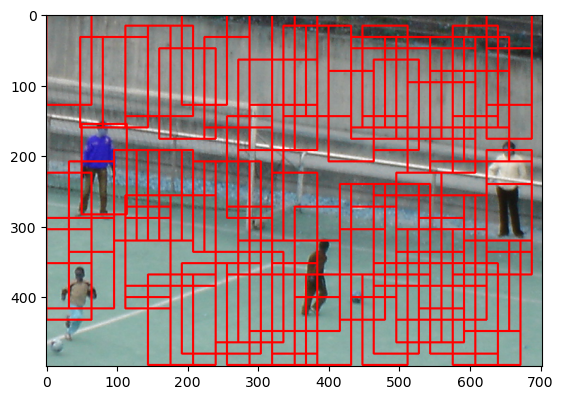

In [12]:
YY, XX = 128, 64
img_copy = img.copy()

for y in range(0, img.shape[0] - YY, 16):
    for x in range(0, img.shape[1] - XX, 16):
        window = img[y:y+YY, x:x+XX]
        F = hog(window)
        F = F.reshape(1, -1)
        prediction = clf.predict(F)
        if prediction == 1:
            cv2.rectangle(img_copy, (x, y), (x + XX, y + YY), (255, 0, 0), 2)

plt.imshow(img_copy)
        